<a href="https://colab.research.google.com/github/atiwari18/BuffERT/blob/main/Hybrid_Stock_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Required Package Imports

In [ ]:
!pip install newsapi-python

## Required Import Statements

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from newsapi import NewsApiClient
from datetime import date, timedelta, datetime
import time
#import yfinance as yf

## Data Preparation
Below, we work to prepare the dataset that will be used to train the model.

In [ ]:
stock_df = pd.read_csv('stock_features.csv')
unique = stock_df['Ticker'].unique()
unique

array(['ABBV', 'ADBE', 'ADI', 'ABNB', 'ZTS', 'XOM', 'JNJ', 'ACN', 'CMCSA',
       'LMT', 'MSFT', 'AAPL', 'GOOGL', 'AMZN', 'TSLA'], dtype=object)

In [ ]:
#Function to retrieve data from the last 30 days.
def fetch_news_last_30_days(api_key, ticker_queries):
    newsapi = NewsApiClient(api_key=api_key)

    # Define date range: last 30 days up to yesterday
    end_date = datetime.now().date() - timedelta(days=1)
    start_date = end_date - timedelta(days=29)
    date_range = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d').tolist()

    print(f"Fetching news from {start_date} to {end_date}")

    all_articles = []

    for ticker, queries in ticker_queries.items():
        print(f"\nFetching news for ticker: {ticker}")
        for query in queries:
            print(f" - Using query: '{query}'")
            for single_date in date_range:
                try:
                    response = newsapi.get_everything(
                        q=query,
                        from_param=single_date,
                        to=single_date,
                        language="en",
                        sort_by="publishedAt",
                        page_size=100,
                        page=1  # Only 1 page allowed for free tier
                    )

                    articles = response.get('articles', [])
                    if articles:
                        print(f"{single_date}: Found {len(articles)} articles for query '{query}'")
                        for article in articles:
                            all_articles.append({
                                'ticker': ticker,
                                'date': pd.to_datetime(article.get('publishedAt', '')).strftime('%Y-%m-%d'),
                                'headline': article.get('title', ''),
                                'source': article.get('source', {}).get('name', ''),
                                'url': article.get('url')
                            })

                except Exception as e:
                    print(f"Error on {single_date} for query '{query}': {str(e)}")

    # Remove duplicates by URL
    news_df = pd.DataFrame(all_articles).drop_duplicates(subset='url')

    # Sort by date
    if not news_df.empty:
        news_df = news_df.sort_values('date', ascending=False)

    return news_df

In [ ]:
ticker_queries_1 = {
    "ABBV": ["AbbVie Inc"],
    "ADBE": ["Adobe Inc"],
    "ADI": ["Analog Devices"]
}

ticker_queries_2 = {
    "ABNB": ["Airbnb Inc"],
    "ZTS": ["Zoetis Inc"],
    "XOM": ["Exxon Mobil Corporation"],
}

ticker_queries_3 = {
    "JNJ": ["Johnson & Johnson"],
    "ACN": ["Accenture plc"],
    "CMCSA": ["Comcast Corporation"],
}

ticker_queries_4 = {
    "LMT": ["Lockheed Martin Corporation"],
    "MSFT": ["Microsoft Corporation"],
    "AAPL": ["Apple Inc"],
}

ticker_queries_5 = {
    "GOOGL": ["Alphabet Inc"],
    "AMZN": ["Amazon.com Inc"],
    "TSLA": ["Tesla Inc"]
}

API_KEY = "59e2b8715dad4b699439767f8c6b2dea"
API_KEY_2 = "9e8195302fb84178a02c8d5c311a7985"
API_KEY_3 = "cc78eff15a164041b81a977c8a5f9fea"
API_KEY_4 = "c4b910abc06c4dac90a60895b3e8b9bc"
API_KEY_5 = "8a07d030a265496ebbf4982623df6028"

In [ ]:
news_df = fetch_news_last_30_days(API_KEY, ticker_queries_1)

Fetching news from 2025-04-06 to 2025-05-05

Fetching news for ticker: ABBV
 - Using query: 'AbbVie Inc'
2025-04-06: Found 1 articles for query 'AbbVie Inc'
2025-04-07: Found 8 articles for query 'AbbVie Inc'
2025-04-08: Found 7 articles for query 'AbbVie Inc'
2025-04-09: Found 6 articles for query 'AbbVie Inc'
2025-04-10: Found 4 articles for query 'AbbVie Inc'
2025-04-11: Found 5 articles for query 'AbbVie Inc'
2025-04-13: Found 6 articles for query 'AbbVie Inc'
2025-04-14: Found 4 articles for query 'AbbVie Inc'
2025-04-15: Found 4 articles for query 'AbbVie Inc'
2025-04-16: Found 9 articles for query 'AbbVie Inc'
2025-04-17: Found 8 articles for query 'AbbVie Inc'
2025-04-18: Found 8 articles for query 'AbbVie Inc'
2025-04-19: Found 6 articles for query 'AbbVie Inc'
2025-04-20: Found 7 articles for query 'AbbVie Inc'
2025-04-21: Found 6 articles for query 'AbbVie Inc'
2025-04-22: Found 4 articles for query 'AbbVie Inc'
2025-04-23: Found 8 articles for query 'AbbVie Inc'
2025-04-24:

,ticker,date,headline,source,url
766,ADI,2025-05-05,Tata Electronics taps chip giant NXP to bag or...,The Times of India,https://economictimes.indiatimes.com/tech/tech...
760,ADI,2025-05-05,Is This the Worst-Ever Era of American Pop Cul...,The Atlantic,https://www.theatlantic.com/magazine/archive/2...
150,ABBV,2025-05-05,Teva and Alvotech Announce FDA Approval of Int...,GlobeNewswire,https://www.globenewswire.com/news-release/202...
151,ABBV,2025-05-05,Teva and Alvotech Announce FDA Approval of Int...,GlobeNewswire,https://www.globenewswire.com/news-release/202...
152,ABBV,2025-05-05,Pharmaceutical Stocks To Research – May 3rd,ETF Daily News,https://www.etfdailynews.com/2025/05/05/pharma...
153,ABBV,2025-05-05,Best Biotech Stocks To Research – May 3rd,ETF Daily News,https://www.etfdailynews.com/2025/05/05/best-b...
765,ADI,2025-05-05,Ola’s brand move; Tata looks to go Dutch,The Times of India,https://economictimes.indiatimes.com/tech/news...
764,ADI,2025-05-05,Skyworks Solutions (SWKS) to Release Earnings ...,ETF Daily News,https://www.etfdailynews.com/2025/05/05/skywor...
763,ADI,2025-05-05,Penguin Solutions (NASDAQ:PENG) and Silicon La...,ETF Daily News,https://www.etfdailynews.com/2025/05/05/pengui...
762,ADI,2025-05-05,Financial Comparison: MACOM Technology Solutio...,ETF Daily News,https://www.etfdailynews.com/2025/05/05/financ...


In [ ]:
news_df_2 = fetch_news_last_30_days(API_KEY_2, ticker_queries_2)

Fetching news from 2025-04-06 to 2025-05-05

Fetching news for ticker: ABNB
 - Using query: 'Airbnb Inc'
2025-04-06: Found 2 articles for query 'Airbnb Inc'
2025-04-07: Found 1 articles for query 'Airbnb Inc'
2025-04-08: Found 1 articles for query 'Airbnb Inc'
2025-04-09: Found 2 articles for query 'Airbnb Inc'
2025-04-10: Found 2 articles for query 'Airbnb Inc'
2025-04-11: Found 2 articles for query 'Airbnb Inc'
2025-04-16: Found 2 articles for query 'Airbnb Inc'
2025-04-18: Found 1 articles for query 'Airbnb Inc'
2025-04-19: Found 3 articles for query 'Airbnb Inc'
2025-04-20: Found 1 articles for query 'Airbnb Inc'
2025-04-21: Found 2 articles for query 'Airbnb Inc'
2025-04-22: Found 2 articles for query 'Airbnb Inc'
2025-04-23: Found 2 articles for query 'Airbnb Inc'
2025-04-24: Found 1 articles for query 'Airbnb Inc'
2025-04-26: Found 2 articles for query 'Airbnb Inc'
2025-04-28: Found 4 articles for query 'Airbnb Inc'
2025-04-29: Found 6 articles for query 'Airbnb Inc'
2025-04-30:

In [ ]:
news_df_3 = fetch_news_last_30_days(API_KEY_3, ticker_queries_3)

Fetching news from 2025-04-06 to 2025-05-05

Fetching news for ticker: JNJ
 - Using query: 'Johnson & Johnson'
2025-04-06: Found 97 articles for query 'Johnson & Johnson'
2025-04-07: Found 92 articles for query 'Johnson & Johnson'
2025-04-08: Found 95 articles for query 'Johnson & Johnson'
2025-04-09: Found 93 articles for query 'Johnson & Johnson'
2025-04-10: Found 91 articles for query 'Johnson & Johnson'
2025-04-11: Found 94 articles for query 'Johnson & Johnson'
2025-04-12: Found 90 articles for query 'Johnson & Johnson'
2025-04-13: Found 88 articles for query 'Johnson & Johnson'
2025-04-14: Found 92 articles for query 'Johnson & Johnson'
2025-04-15: Found 93 articles for query 'Johnson & Johnson'
2025-04-16: Found 94 articles for query 'Johnson & Johnson'
2025-04-17: Found 92 articles for query 'Johnson & Johnson'
2025-04-18: Found 97 articles for query 'Johnson & Johnson'
2025-04-19: Found 89 articles for query 'Johnson & Johnson'
2025-04-20: Found 91 articles for query 'Johnson 

In [ ]:
news_df_4 = fetch_news_last_30_days(API_KEY_4, ticker_queries_4)

Fetching news from 2025-04-06 to 2025-05-05

Fetching news for ticker: LMT
 - Using query: 'Lockheed Martin Corporation'
2025-04-06: Found 2 articles for query 'Lockheed Martin Corporation'
2025-04-07: Found 3 articles for query 'Lockheed Martin Corporation'
2025-04-08: Found 2 articles for query 'Lockheed Martin Corporation'
2025-04-09: Found 3 articles for query 'Lockheed Martin Corporation'
2025-04-11: Found 1 articles for query 'Lockheed Martin Corporation'
2025-04-13: Found 3 articles for query 'Lockheed Martin Corporation'
2025-04-14: Found 2 articles for query 'Lockheed Martin Corporation'
2025-04-15: Found 5 articles for query 'Lockheed Martin Corporation'
2025-04-16: Found 3 articles for query 'Lockheed Martin Corporation'
2025-04-17: Found 6 articles for query 'Lockheed Martin Corporation'
2025-04-20: Found 1 articles for query 'Lockheed Martin Corporation'
2025-04-21: Found 9 articles for query 'Lockheed Martin Corporation'
2025-04-22: Found 12 articles for query 'Lockheed M

In [ ]:
news_df_5 = fetch_news_last_30_days(API_KEY_5, ticker_queries_5)

Fetching news from 2025-04-06 to 2025-05-05

Fetching news for ticker: GOOGL
 - Using query: 'Alphabet Inc'
2025-04-06: Found 16 articles for query 'Alphabet Inc'
2025-04-07: Found 18 articles for query 'Alphabet Inc'
2025-04-08: Found 30 articles for query 'Alphabet Inc'
2025-04-09: Found 17 articles for query 'Alphabet Inc'
2025-04-10: Found 34 articles for query 'Alphabet Inc'
2025-04-11: Found 33 articles for query 'Alphabet Inc'
2025-04-12: Found 13 articles for query 'Alphabet Inc'
2025-04-13: Found 6 articles for query 'Alphabet Inc'
2025-04-14: Found 13 articles for query 'Alphabet Inc'
2025-04-15: Found 18 articles for query 'Alphabet Inc'
2025-04-16: Found 13 articles for query 'Alphabet Inc'
2025-04-17: Found 28 articles for query 'Alphabet Inc'
2025-04-18: Found 17 articles for query 'Alphabet Inc'
2025-04-19: Found 24 articles for query 'Alphabet Inc'
2025-04-20: Found 12 articles for query 'Alphabet Inc'
2025-04-21: Found 33 articles for query 'Alphabet Inc'
2025-04-22: F

In [ ]:
#The 5 separate dataframes
dfs = [news_df, news_df_2, news_df_3, news_df_4, news_df_5]

# Concatenate them vertically (row-wise)
combined_df = pd.concat(dfs, ignore_index=True)

# Save to CSV
combined_df.to_csv('combined_news_data.csv', index=False)

print("Combined DataFrame saved as 'combined_news_data.csv'")

Combined DataFrame saved as 'combined_news_data.csv'


In [ ]:
combined_df = pd.read_csv("combined_news_data.csv")

#### Generating Embeddings
For this step we generate the embeddings from the FinBERT model and then we use the autoencoder to reconstruct them to 128-dimensional vectors.

In [ ]:
def load_finbert_model(model_path):
    # Define the model architecture
    model = FinBERTAutoencoder(input_dim=768, latent_dim=128)

    # Load the saved weights
    try:
        model.load_state_dict(torch.load(model_path))
        print(f"Successfully loaded FinBERT autoencoder from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

    # Set to evaluation mode
    model.eval()
    return model

def get_finbert_embeddings(headlines, model_name="yiyanghkust/finbert-tone", batch_size=64):
    # Load FinBERT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    print(f"Generating FinBERT embeddings for {len(headlines)} headlines using {device}...")

    # Generate embeddings in batches
    all_embeddings = []

    # Process headlines in batches to avoid memory issues
    for i in tqdm(range(0, len(headlines), batch_size)):
        batch = headlines[i:i+batch_size]

        # Tokenize headlines
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        )

        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Get CLS token embeddings from the last hidden state
        # CLS token is the first token [0] in the sequence
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeddings)

    # Concatenate all batches
    return np.vstack(all_embeddings)

def add_embeddings_to_df(df, headline_column='headline', model_name="yiyanghkust/finbert-tone", batch_size=32):
    # Create a copy of the dataframe
    result_df = df.copy()

    # Get list of headlines
    headlines = result_df[headline_column].tolist()

    # Generate embeddings
    embeddings = get_finbert_embeddings(headlines, model_name, batch_size)

    # Store embeddings as a new column
    # Since embeddings are vectors, we store them as lists
    result_df['finbert_embedding'] = embeddings.tolist()

    return result_df, embeddings

In [ ]:
# Get embeddings and add to dataframe
result_df, embeddings = add_embeddings_to_df(combined_df)
result_df.head()

Generating FinBERT embeddings for 8337 headlines using cuda...


100%|██████████| 261/261 [00:16<00:00, 15.85it/s]


,ticker,date,headline,source,url,finbert_embedding
0,ADI,2025-05-05,Tata Electronics taps chip giant NXP to bag or...,The Times of India,https://economictimes.indiatimes.com/tech/tech...,"[-0.44852888584136963, -0.9885561466217041, -1..."
1,ADI,2025-05-05,Is This the Worst-Ever Era of American Pop Cul...,The Atlantic,https://www.theatlantic.com/magazine/archive/2...,"[0.16554871201515198, -0.6732075214385986, -1...."
2,ABBV,2025-05-05,Teva and Alvotech Announce FDA Approval of Int...,GlobeNewswire,https://www.globenewswire.com/news-release/202...,"[0.3356679379940033, -0.8024927973747253, -0.5..."
3,ABBV,2025-05-05,Teva and Alvotech Announce FDA Approval of Int...,GlobeNewswire,https://www.globenewswire.com/news-release/202...,"[0.3356679379940033, -0.8024927973747253, -0.5..."
4,ABBV,2025-05-05,Pharmaceutical Stocks To Research – May 3rd,ETF Daily News,https://www.etfdailynews.com/2025/05/05/pharma...,"[-0.5236151814460754, -1.0628291368484497, -1...."


In [ ]:
# Ensure 'date' is in datetime format just in case
result_df['date'] = pd.to_datetime(result_df['date'])

# Convert embedding column to numpy arrays if not already
result_df['finbert_embedding'] = result_df['finbert_embedding'].apply(np.array)

# Group by ticker and date and average the embeddings
daily_embeddings = result_df.groupby(['ticker', 'date'])['finbert_embedding'].apply(
    lambda vectors: np.mean(vectors.tolist(), axis=0)
).reset_index()

daily_embeddings.head(20)

,ticker,date,finbert_embedding
0,AAPL,2025-04-06,"[0.18333759029666263, -0.5176284340240301, -0...."
1,AAPL,2025-04-07,"[0.16729204551804633, -0.5571130540088883, -0...."
2,AAPL,2025-04-08,"[0.14740683112970807, -0.5492765878708187, -1...."
3,AAPL,2025-04-09,"[0.14823752615600824, -0.5772965272516012, -0...."
4,AAPL,2025-04-10,"[0.09516986775352566, -0.49001908555345713, -0..."
5,AAPL,2025-04-11,"[0.23947202727743766, -0.6771024802654255, -0...."
6,AAPL,2025-04-12,"[0.38442690085087505, -1.0393397616488593, -0...."
7,AAPL,2025-04-13,"[0.16093131687375717, -0.5270790710346773, -1...."
8,AAPL,2025-04-14,"[0.12206852887693333, -0.5286294863087265, -0...."
9,AAPL,2025-04-15,"[0.18685644740859667, -0.8472406928324037, -0...."


Now we will generate the 128-dimensional embeddings and concatenate the dataset with the price data.

In [ ]:
def process_finbert_embeddings(finbert_df, autoencoder_model, embedding_column='finbert_embedding', device='cuda'):
    # Extract the raw embeddings
    if embedding_column not in finbert_df.columns:
        raise ValueError(f"Column '{embedding_column}' not found in the DataFrame")

    # Convert embeddings to tensor
    embeddings_list = finbert_df[embedding_column].tolist()
    embeddings_tensor = torch.tensor(embeddings_list, dtype=torch.float32).to(device)

    # Process in batches to avoid memory issues
    batch_size = 64
    encoded_embeddings = []

    with torch.no_grad():
        for i in range(0, len(embeddings_tensor), batch_size):
            batch = embeddings_tensor[i:i+batch_size]
            encoded_batch = autoencoder_model.encode(batch)
            encoded_embeddings.append(encoded_batch.cpu().numpy())

    # Concatenate all batches
    encoded_embeddings = np.vstack(encoded_embeddings)

    # Add the encoded embeddings to the dataframe
    finbert_df['encoded_embedding'] = list(encoded_embeddings)

    return finbert_df

In [ ]:
# Step 1: Normalize column names for merging
processed_df_renamed = result_df.rename(columns={
    'date': 'Date',
    'ticker': 'Ticker'
})

# Ensure both Date columns are datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
processed_df_renamed['Date'] = pd.to_datetime(processed_df_renamed['Date'])

# Step 2: Merge on Date and Ticker (inner join to keep only matches)
merged_df = stock_df.merge(
    processed_df_renamed[['Date', 'Ticker', 'finbert_embedding']],
    on=['Date', 'Ticker'],
    how='left'  # Use 'left' to preserve all rows in target_df
)

# Remove rows with NaN in encoded_embedding
clean_df = merged_df.dropna(subset=['finbert_embedding'])

clean_df.to_csv("stock_features_embeddings.csv")

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Load FinBERT autoencoder model
print("Loading FinBERT autoencoder model...")
autoencoder_model = load_finbert_model("final_model.pth").to(device)

#Process FinBERT Embeddings through autoencoder
print("Processing FinBERT embeddings...")
processed_df = process_finbert_embeddings(clean_df, autoencoder_model, device=device)
processed_df.to_csv("stock_features_encoded_embeddings.csv")

Using device: cuda

Loading FinBERT autoencoder model...
Successfully loaded FinBERT autoencoder from final_model.pth
Processing FinBERT embeddings...


<ipython-input-8-b6791ab625cf>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings_tensor = torch.tensor(embeddings_list, dtype=torch.float32).to(device)
<ipython-input-8-b6791ab625cf>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finbert_df['encoded_embedding'] = list(encoded_embeddings)


In [ ]:
processed_df.shape

(6182, 16)

In [ ]:
def prepare_hybrid_data(combined_df, seq_len, price_feature_cols, sentiment_col, ticker_col=None, date_col=None):
    X_price = []  # Price sequences
    X_sentiment = []  # Sentiment embeddings
    y_day = []  # Next day labels
    y_week = []  # Next week labels

    # Check if date is in index or column
    if isinstance(combined_df.index, pd.DatetimeIndex):
        df = combined_df.copy()
    else:
        if date_col is None:
            raise ValueError("date_col must be specified if DataFrame doesn't have DatetimeIndex")
        df = combined_df.copy()
        df['date'] = pd.to_datetime(df[date_col])

    # Process by ticker if ticker_col is provided, otherwise process entire dataframe
    tickers = [None]
    if ticker_col is not None:
        tickers = df[ticker_col].unique()

    for ticker in tqdm(tickers, desc="Processing data"):
        # Filter by ticker if needed
        if ticker is not None:
            ticker_df = df[df[ticker_col] == ticker].sort_values('date' if date_col is None else date_col)
        else:
            ticker_df = df.sort_values('date' if date_col is None else date_col)

        # Create sequences and labels
        for i in range(seq_len, len(ticker_df) - 20):
            # Extract price sequence
            price_seq = ticker_df.iloc[i-seq_len:i][price_feature_cols].values

            # Extract sentiment embedding
            sentiment_embedding = get_sentiment_embedding(ticker_df.iloc[i], sentiment_col)

            # Labels
            next_day_label = ticker_df.iloc[i]['Label_Next_Day']
            next_week_label = ticker_df.iloc[i]['Label_Next_Week']

            # Append to lists
            X_price.append(price_seq)
            X_sentiment.append(sentiment_embedding)
            y_day.append(next_day_label)
            y_week.append(next_week_label)

    # Convert to numpy arrays
    X_price = np.array(X_price)
    X_sentiment = np.array(X_sentiment)
    y_day = np.array(y_day)
    y_week = np.array(y_week)

    print(f"Processed data shapes:")
    print(f"Price data: {X_price.shape}")
    print(f"Sentiment data: {X_sentiment.shape}")
    print(f"Day labels: {y_day.shape}")
    print(f"Week labels: {y_week.shape}")

    # Split data
    # First split to get test set
    X_price_temp, X_price_test, X_sent_temp, X_sent_test, y_day_temp, y_day_test, y_week_temp, y_week_test = train_test_split(
        X_price, X_sentiment, y_day, y_week, test_size=0.1, shuffle=True, random_state=42)

    # Then split temp data into train and validation
    X_price_train, X_price_val, X_sent_train, X_sent_val, y_day_train, y_day_val, y_week_train, y_week_val = train_test_split(
        X_price_temp, X_sent_temp, y_day_temp, y_week_temp, test_size=0.1111, shuffle=True, random_state=42)

    # Convert to tensors
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_price_train = torch.tensor(X_price_train, dtype=torch.float32).to(device)
    X_price_val = torch.tensor(X_price_val, dtype=torch.float32).to(device)
    X_price_test = torch.tensor(X_price_test, dtype=torch.float32).to(device)

    X_sent_train = torch.tensor(X_sent_train, dtype=torch.float32).to(device)
    X_sent_val = torch.tensor(X_sent_val, dtype=torch.float32).to(device)
    X_sent_test = torch.tensor(X_sent_test, dtype=torch.float32).to(device)

    y_day_train = torch.tensor(y_day_train, dtype=torch.long).to(device)
    y_day_val = torch.tensor(y_day_val, dtype=torch.long).to(device)
    y_day_test = torch.tensor(y_day_test, dtype=torch.long).to(device)

    y_week_train = torch.tensor(y_week_train, dtype=torch.long).to(device)
    y_week_val = torch.tensor(y_week_val, dtype=torch.long).to(device)
    y_week_test = torch.tensor(y_week_test, dtype=torch.long).to(device)

    # Create dataset dictionary
    dataset = {
        'train': {
            'price': X_price_train,
            'sentiment': X_sent_train,
            'day_labels': y_day_train,
            'week_labels': y_week_train
        },
        'val': {
            'price': X_price_val,
            'sentiment': X_sent_val,
            'day_labels': y_day_val,
            'week_labels': y_week_val
        },
        'test': {
            'price': X_price_test,
            'sentiment': X_sent_test,
            'day_labels': y_day_test,
            'week_labels': y_week_test
        }
    }

    return dataset


def get_sentiment_embedding(row, sentiment_col):
    embedding = row[sentiment_col]

    # Convert to numpy array if it's a list
    if isinstance(embedding, list):
        embedding = np.array(embedding)

    return embedding


def create_dataloaders(dataset, batch_size=32):
    # Create TensorDatasets
    train_dataset = TensorDataset(
        dataset['train']['price'],
        dataset['train']['sentiment'],
        dataset['train']['day_labels'],
        dataset['train']['week_labels']
    )

    val_dataset = TensorDataset(
        dataset['val']['price'],
        dataset['val']['sentiment'],
        dataset['val']['day_labels'],
        dataset['val']['week_labels']
    )

    test_dataset = TensorDataset(
        dataset['test']['price'],
        dataset['test']['sentiment'],
        dataset['test']['day_labels'],
        dataset['test']['week_labels']
    )

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

## Model Architectures
This section details the models that we will use for our Hybrid approach. The first model is called "Price Encoder" and is derived from the sub-group within our team that worked on the price specific prediction model. The other model is FinBERT where an autoencoder's encoder is used to downsample the [CLS] token to being 128-dimensional.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

#Transformer Model for Price Prediction
class PriceEncoder(nn.Module):
    """
    Price data encoder using transformer architecture
    """
    def __init__(self, feature_size, hidden_dim=128, nhead=4, num_layers=4):
        super().__init__()
        self.embedding = nn.Linear(feature_size, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True, dropout=0.2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        # Return sequence output for cross-attention and pooled output for classification
        sequence_output = x
        pooled_output = x.mean(dim=1)
        return sequence_output, pooled_output

#FinBERT with an Autoencoder to downsample down to 128-dimensions
class FinBERTAutoencoder(nn.Module):
    def __init__(self, input_dim=768, latent_dim=128):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        # Decoder (for training)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def encode(self, x):
        # For inference only
        return self.encoder(x)

#Cross Attention Layer
class CrossAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5

        # Multi-head attention
        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context):
        h = self.heads

        # Split heads
        q = self.to_q(x).reshape(x.shape[0], -1, h, x.shape[-1] // h).permute(0, 2, 1, 3)
        k = self.to_k(context).reshape(context.shape[0], -1, h, context.shape[-1] // h).permute(0, 2, 1, 3)
        v = self.to_v(context).reshape(context.shape[0], -1, h, context.shape[-1] // h).permute(0, 2, 1, 3)

        # Compute attention
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(dots, dim=-1)
        out = torch.matmul(attn, v)

        # Reshape and project
        out = out.permute(0, 2, 1, 3).reshape(x.shape[0], -1, x.shape[-1])
        return self.to_out(out)

#Hybrid Model
class HybridStockPredictor(nn.Module):
    def __init__(self,
                 price_feature_size,
                 sentiment_dim=128,
                 hidden_dim=128,
                 nhead=4,
                 num_layers=4,
                 num_classes=2):
        super().__init__()

        # Price encoder
        self.price_encoder = PriceEncoder(
            feature_size=price_feature_size,
            hidden_dim=hidden_dim,
            nhead=nhead,
            num_layers=num_layers
        )

        # Sentiment projection (if dimensions don't match)
        self.sentiment_projection = nn.Linear(sentiment_dim, hidden_dim)

        # Cross-attention layers
        self.price_to_sentiment = CrossAttention(dim=hidden_dim)
        self.sentiment_to_price = CrossAttention(dim=hidden_dim)

        # Layer norms
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # MLP for classification
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Output heads for different time horizons
        self.fc_day = nn.Linear(hidden_dim // 2, num_classes)
        self.fc_week = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, price_data, sentiment_data):
        # Process price data
        price_seq, price_pooled = self.price_encoder(price_data)

        # Project sentiment data to match dimensions
        sentiment_projected = self.sentiment_projection(sentiment_data)
        # Reshape for cross-attention if needed
        sentiment_expanded = sentiment_projected.unsqueeze(1)  # [batch, 1, hidden_dim]

        # Cross attention: price attends to sentiment
        attended_price = self.price_to_sentiment(price_seq, sentiment_expanded)
        price_fused = self.norm1(price_seq + attended_price)

        # Get attended price representation
        price_fused_pooled = price_fused.mean(dim=1)

        # Cross attention: sentiment attends to price
        attended_sentiment = self.sentiment_to_price(sentiment_expanded, price_seq)
        sentiment_fused = self.norm2(sentiment_expanded + attended_sentiment)
        sentiment_fused = sentiment_fused.squeeze(1)  # [batch, hidden_dim]

        # Concatenate features for final prediction
        combined_features = torch.cat([price_fused_pooled, sentiment_fused], dim=1)

        # Final classification
        features = self.classifier(combined_features)

        # Multi-task outputs
        day_pred = self.fc_day(features)
        week_pred = self.fc_week(features)

        return day_pred, week_pred

### Training and Evaluation Functions
Below we have the functions that are used to train and evaluate the Hybrid model that we have. One important note is to understand what Focal Loss is, it is a modified version of cross-entropy loss designed to address class imbalance.

In [ ]:
def train_hybrid_model(model, train_loader, val_loader, epochs=100, lr=1e-4, weight_decay=1e-4, patience=10):
    device = next(model.parameters()).device
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    trigger_times = 0
    best_model_state = None

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_day_metrics': [],
        'val_week_metrics': []
    }

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0

        for price_data, sentiment_data, day_labels, week_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            # DataLoader unpacks the TensorDataset in order
            optimizer.zero_grad()

            day_pred, week_pred = model(price_data, sentiment_data)
            loss = criterion(day_pred, day_labels) + criterion(week_pred, week_labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        all_day_preds = []
        all_day_labels = []
        all_week_preds = []
        all_week_labels = []

        with torch.no_grad():
            for price_data, sentiment_data, day_labels, week_labels in val_loader:
                day_pred, week_pred = model(price_data, sentiment_data)
                val_loss = criterion(day_pred, day_labels) + criterion(week_pred, week_labels)
                val_running_loss += val_loss.item()

                all_day_preds.append(day_pred)
                all_day_labels.append(day_labels)
                all_week_preds.append(week_pred)
                all_week_labels.append(week_labels)

        avg_val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # Combine validation predictions and calculate metrics
        day_preds = torch.cat(all_day_preds, dim=0)
        day_labels = torch.cat(all_day_labels, dim=0)
        week_preds = torch.cat(all_week_preds, dim=0)
        week_labels = torch.cat(all_week_labels, dim=0)

        day_metrics = calculate_metrics(day_preds, day_labels)
        week_metrics = calculate_metrics(week_preds, week_labels)

        history['val_day_metrics'].append(day_metrics)
        history['val_week_metrics'].append(week_metrics)

        scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
            best_model_state = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch+1) % 5 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - LR: {current_lr:.6f}")
            print(f"Val Day Metrics - Acc: {day_metrics['accuracy']:.4f}, Precision: {day_metrics['precision']:.4f}, Recall: {day_metrics['recall']:.4f}, F1: {day_metrics['f1']:.4f}")
            print(f"Val Week Metrics - Acc: {week_metrics['accuracy']:.4f}, Precision: {week_metrics['precision']:.4f}, Recall: {week_metrics['recall']:.4f}, F1: {week_metrics['f1']:.4f}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history


def calculate_metrics(preds, targets):
    preds_cls = preds.argmax(dim=1).cpu().numpy()
    targets_np = targets.cpu().numpy()

    return {
        'accuracy': accuracy_score(targets_np, preds_cls),
        'precision': precision_score(targets_np, preds_cls, zero_division=0),
        'recall': recall_score(targets_np, preds_cls, zero_division=0),
        'f1': f1_score(targets_np, preds_cls, zero_division=0)
    }


def evaluate_model(model, test_loader):
    """Evaluate model on test data"""
    device = next(model.parameters()).device
    model.eval()

    all_day_preds = []
    all_day_labels = []
    all_week_preds = []
    all_week_labels = []

    with torch.no_grad():
        for price_data, sentiment_data, day_labels, week_labels in test_loader:
            day_pred, week_pred = model(price_data, sentiment_data)

            all_day_preds.append(day_pred)
            all_day_labels.append(day_labels)
            all_week_preds.append(week_pred)
            all_week_labels.append(week_labels)

    # Combine test predictions
    day_preds = torch.cat(all_day_preds, dim=0)
    day_labels = torch.cat(all_day_labels, dim=0)
    week_preds = torch.cat(all_week_preds, dim=0)
    week_labels = torch.cat(all_week_labels, dim=0)

    # Calculate metrics
    day_metrics = calculate_metrics(day_preds, day_labels)
    week_metrics = calculate_metrics(week_preds, week_labels)

    print("\n=== Hybrid Model Test Results ===")
    print(f"Next Day  - Acc: {day_metrics['accuracy']:.4f}, Prec: {day_metrics['precision']:.4f}, Rec: {day_metrics['recall']:.4f}, F1: {day_metrics['f1']:.4f}")
    print(f"Next Week - Acc: {week_metrics['accuracy']:.4f}, Prec: {week_metrics['precision']:.4f}, Rec: {week_metrics['recall']:.4f}, F1: {week_metrics['f1']:.4f}")

    return day_metrics, week_metrics


def plot_training_history(history):
    plt.figure(figsize=(12, 8))

    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot day metrics
    plt.subplot(2, 2, 2)
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = [metrics[metric] for metrics in history['val_day_metrics']]
        plt.plot(values, label=f'Day {metric.capitalize()}')
    plt.title('Next Day Prediction Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    # Plot week metrics
    plt.subplot(2, 2, 3)
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = [metrics[metric] for metrics in history['val_week_metrics']]
        plt.plot(values, label=f'Week {metric.capitalize()}')
    plt.title('Next Week Prediction Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Define your feature columns
FEATURE_COLUMNS = ['Close', 'Return', 'MA7', 'MA14', 'MACD', 'Signal_Line', 'Rolling_Volatility']

# Identify your sentiment embedding column
SENTIMENT_COL = 'encoded_embedding'

# If you have a date column and it's not the index
DATE_COL = 'Date'

# If you have multiple tickers in your dataframe
TICKER_COL = 'Ticker'

# Set sequence length - how many prior days of data to use for each prediction
SEQ_LEN = 30

# Prepare the data correctly
dataset = prepare_hybrid_data(
    combined_df=processed_df,  # Your dataframe with all data
    seq_len=SEQ_LEN,
    price_feature_cols=FEATURE_COLUMNS,
    sentiment_col=SENTIMENT_COL,
    ticker_col=TICKER_COL,  # Set to None if not needed
    date_col=DATE_COL  # Set to None if using DateTimeIndex
)

# Create dataloaders for training
train_loader, val_loader, test_loader = create_dataloaders(dataset, batch_size=32)

Processing data: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

Processed data shapes:
Price data: (5471, 30, 7)
Sentiment data: (5471, 128)
Day labels: (5471,)
Week labels: (5471,)


Model initialized on cuda
Total parameters: 2564036


Epoch 1/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 49.83it/s]


Epoch 1/100 - Train Loss: 0.0808 - Val Loss: 0.0642 - LR: 0.000100
Val Day Metrics - Acc: 0.6234, Precision: 0.6123, Recall: 0.7897, F1: 0.6898
Val Week Metrics - Acc: 0.8318, Precision: 0.8218, Recall: 0.8676, F1: 0.8441


Epoch 5/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 63.65it/s]


Epoch 5/100 - Train Loss: 0.0398 - Val Loss: 0.0351 - LR: 0.000100
Val Day Metrics - Acc: 0.8373, Precision: 0.7982, Recall: 0.9276, F1: 0.8581
Val Week Metrics - Acc: 0.9415, Precision: 0.9264, Recall: 0.9652, F1: 0.9454


Epoch 10/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 63.78it/s]


Epoch 10/100 - Train Loss: 0.0244 - Val Loss: 0.0218 - LR: 0.000100
Val Day Metrics - Acc: 0.9104, Precision: 0.8731, Recall: 0.9724, F1: 0.9201
Val Week Metrics - Acc: 0.9671, Precision: 0.9753, Recall: 0.9617, F1: 0.9684


Epoch 15/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 64.21it/s]


Epoch 15/100 - Train Loss: 0.0178 - Val Loss: 0.0162 - LR: 0.000100
Val Day Metrics - Acc: 0.9342, Precision: 0.9071, Recall: 0.9759, F1: 0.9402
Val Week Metrics - Acc: 0.9744, Precision: 0.9723, Recall: 0.9791, F1: 0.9757


Epoch 20/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 63.71it/s]


Epoch 20/100 - Train Loss: 0.0133 - Val Loss: 0.0175 - LR: 0.000100
Val Day Metrics - Acc: 0.9269, Precision: 0.9195, Recall: 0.9448, F1: 0.9320
Val Week Metrics - Acc: 0.9689, Precision: 0.9655, Recall: 0.9756, F1: 0.9705


Epoch 25/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 64.04it/s]


Epoch 25/100 - Train Loss: 0.0108 - Val Loss: 0.0151 - LR: 0.000050
Val Day Metrics - Acc: 0.9378, Precision: 0.9295, Recall: 0.9552, F1: 0.9422
Val Week Metrics - Acc: 0.9799, Precision: 0.9964, Recall: 0.9652, F1: 0.9805


Epoch 30/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 63.46it/s]


Epoch 30/100 - Train Loss: 0.0080 - Val Loss: 0.0190 - LR: 0.000025
Val Day Metrics - Acc: 0.9378, Precision: 0.9156, Recall: 0.9724, F1: 0.9431
Val Week Metrics - Acc: 0.9762, Precision: 0.9724, Recall: 0.9826, F1: 0.9775


Epoch 33/100 - Training: 100%|██████████| 137/137 [00:02<00:00, 53.72it/s]


Early stopping at epoch 33

=== Hybrid Model Test Results ===
Next Day  - Acc: 0.9270, Prec: 0.9303, Rec: 0.9303, F1: 0.9303
Next Week - Acc: 0.9781, Prec: 0.9803, Rec: 0.9727, F1: 0.9765


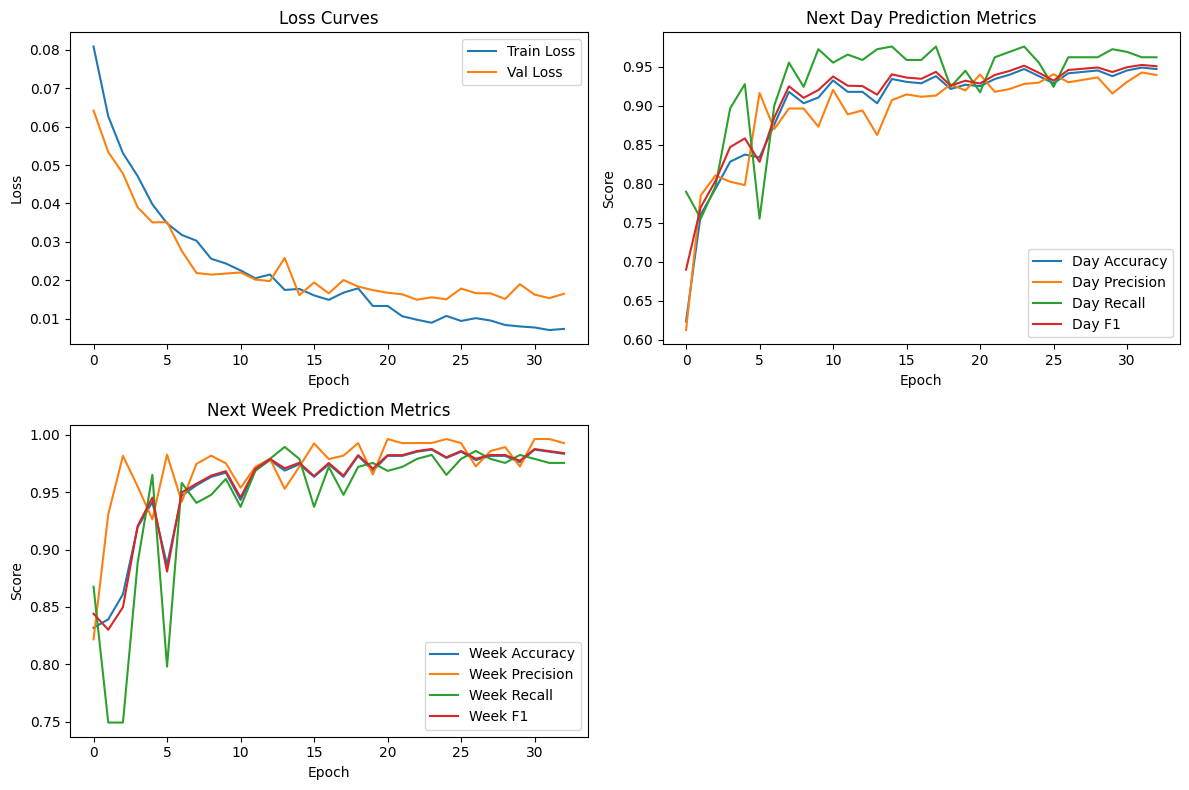

In [ ]:
EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4


#Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridStockPredictor(
    price_feature_size=len(FEATURE_COLUMNS),
    sentiment_dim=dataset['train']['sentiment'].shape[1],  # Get embedding dimension from data
    hidden_dim=128,
    nhead=4,
    num_layers=4,
    num_classes=2  # Binary classification (up/down)
).to(device)

print(f"Model initialized on {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

#Train Model
model, history = train_hybrid_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

#Evaluate on test set
test_metrics = evaluate_model(model, test_loader)

#Plot training history
plot_training_history(history)